In [2]:
import xmitgcm

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import proj3d
import numpy as np

import os

from IPython.display import display, Math
from sympy import *

import seawater as sw

In [3]:
path = '../input'

In [4]:
NX = 80
NY = 42
NZ = 30

dx = 5 # km
dy = 5 # km
dz = 26 # m

f = 1e-4
om = 2*np.pi/86400
lat0 = np.rad2deg(np.arcsin(f/(2*om)))

# Bathymetry

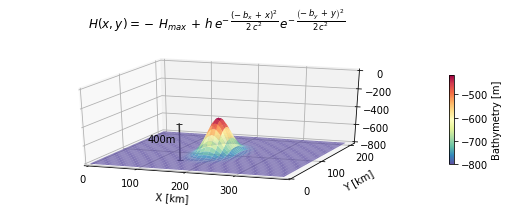

In [12]:
x,y = np.meshgrid(np.arange(0,NX*dx,dx),np.arange(0,NY*dy,dy))

xx = Symbol('x')
yy = Symbol('y')

bx = (NX/2 - 1)*dx
by = (NY/2 - 1)*dy
c = (16*dx/4)

kw = {
    'b_x':(NX/2 - 1)*dx,
    'b_y':(NY/2 - 1)*dy,
    'c':(16*dx/4),
    'H_{max}':800,
    'h':400,
}


topo = Symbol('h')*(exp(-((xx-Symbol('b_x'))**2)/(2*Symbol('c')**2))*exp(-((yy-Symbol('b_y'))**2)/(2*Symbol('c')**2)))-Symbol('H_{max}')

topov = lambdify((xx,yy),topo.subs(kw))(x,y)


fig = plt.figure(figsize=(8,3))
ax = fig.gca(projection='3d')

ax.set_title('$H(x,y) = {}$'.format(latex(topo).replace(' ','\,').replace('frac','dfrac'))+'\n')

C = ax.plot_surface(x, y, topov, cmap='Spectral_r', linewidth=0, antialiased=True, alpha=0.8)
# ax.plot_surface(x, y, topov*0-400, color='k', linewidth=0, antialiased=True, alpha=0.05)

cbar = fig.colorbar(C,ax=ax,fraction=0.01)
cbar.set_label('Bathymetry [m]')

_ = ax.set(
    xlabel='\nX [km]',
    ylabel='\nY [km]',
    xticks=np.arange(0,NX*dx,100),
    yticks=np.arange(0,NY*dy,100),
    zticks=-np.arange(0,800+200,200),
    xlim=[0,NX*dx],
    ylim=[0,NY*dy],
    zlim=[-800,0],
)


ax.plot([150]*2,[50]*2,[-800,-400],marker='_',color='0.2')
ax.text(90,40,-600,'400m',(0,0,0))
ax.view_init(25, -70)
ax.dist = 11

fig.savefig('./img/Init_BAT.png',dpi=300,bbox_inches='tight')

# Eta

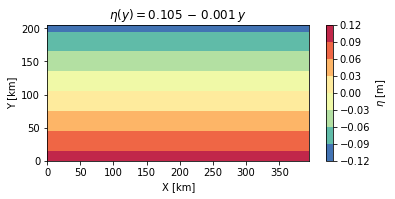

In [13]:
theta = -1e-3
eta = theta*(yy-NY*dy/2)

etav = lambdify((xx,yy),eta)(x,y)

fig,ax = plt.subplots(figsize=(6,2.5))
C = ax.contourf(x,y,etav,cmap='Spectral_r')
ax.axis('scaled')
fig.colorbar(C,label='$\eta$ [m]')

_ = ax.set(
    title='$\eta(y) = {}$'.format(latex(eta).replace(' ','\,').replace('frac','dfrac')),
    xlabel='X [km]',
    ylabel='Y [km]',
)

fig.savefig('./img/Init_ETA.png',dpi=300,bbox_inches='tight')

# Velocity

In [14]:
u = simplify(-(Symbol('g')/Symbol('f'))*Derivative(eta,yy)/1000)
display(Math('$u = {} = {}$'.format(latex(u).replace(' ','\,').replace('frac','dfrac'),N(u.subs({'f':f,'g':9.8}),2))))

<IPython.core.display.Math object>

In [15]:
uv = np.float(u.subs({'f':f,'g':9.8}))*np.ones((NZ,NY,NX))

# Temperature

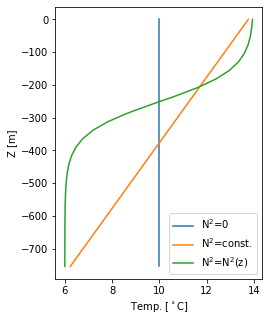

In [16]:
zz = -np.arange(0,NZ*dz,dz)

Tn0 = 0*zz+10
TnC = 1e-2*(zz-zz.mean())+10
TnZ = 4*np.tanh(1e-2*(zz-(2/3)*zz.mean()))+10

fig,ax = plt.subplots(figsize=(3.7,5))

ax.plot(Tn0,zz,label='N$^2$=0')
ax.plot(TnC,zz,label='N$^2$=const.')
ax.plot(TnZ,zz,label='N$^2$=N$^2$(z)')

ax.set(xlabel='Temp. [$^\circ$C]',ylabel='Z [m]')

ax.legend(loc=4)
fig.savefig('./img/Init_Temp.png',dpi=300,bbox_inches='tight')

Tn0 = Tn0[:,np.newaxis,np.newaxis]*np.ones((NZ,NY,NX))
TnC = TnC[:,np.newaxis,np.newaxis]*np.ones((NZ,NY,NX))
TnZ = TnZ[:,np.newaxis,np.newaxis]*np.ones((NZ,NY,NX))



# Saving files

## Initial Conditions

In [182]:
xmitgcm.utils.write_to_binary(topov.flatten(), os.path.join(path,'BAT.bin'),dtype='float64')
xmitgcm.utils.write_to_binary(etav.flatten(), os.path.join(path,'ETA.bin'),dtype='float64')
xmitgcm.utils.write_to_binary(uv.flatten(), os.path.join(path,'U.bin'),dtype='float64')

xmitgcm.utils.write_to_binary(Tn0.flatten(), os.path.join(path,'Temp_N0.bin'),dtype='float64')
xmitgcm.utils.write_to_binary(TnC.flatten(), os.path.join(path,'Temp_NC.bin'),dtype='float64')
xmitgcm.utils.write_to_binary(TnZ.flatten(), os.path.join(path,'Temp_NZ.bin'),dtype='float64')

## Boundaries - North and South

In [182]:
# NORTH AND SOUTH
xmitgcm.utils.write_to_binary(etav[-1].flatten(), os.path.join(path,'ETA_N.bin'),dtype='float64')
xmitgcm.utils.write_to_binary(etav[0].flatten(), os.path.join(path,'ETA_S.bin'),dtype='float64')

xmitgcm.utils.write_to_binary(uv[:,-1,:].flatten(), os.path.join(path,'U_N.bin'),dtype='float64')
xmitgcm.utils.write_to_binary(uv[:,0,:].flatten(), os.path.join(path,'U_S.bin'),dtype='float64')

xmitgcm.utils.write_to_binary(Tn0[:,-1,:].flatten(), os.path.join(path,'Temp_N0_N.bin'),dtype='float64')
xmitgcm.utils.write_to_binary(Tn0[:,0,:].flatten(), os.path.join(path,'Temp_N0_S.bin'),dtype='float64')

xmitgcm.utils.write_to_binary(TnC[:,-1,:].flatten(), os.path.join(path,'Temp_NC_N.bin'),dtype='float64')
xmitgcm.utils.write_to_binary(TnC[:,0,:].flatten(), os.path.join(path,'Temp_NC_S.bin'),dtype='float64')

xmitgcm.utils.write_to_binary(TnZ[:,-1,:].flatten(), os.path.join(path,'Temp_NZ_N.bin'),dtype='float64')
xmitgcm.utils.write_to_binary(TnZ[:,0,:].flatten(), os.path.join(path,'Temp_NZ_S.bin'),dtype='float64')

## Boundaries - West and East

In [182]:
# WEST AND EAST
xmitgcm.utils.write_to_binary(etav[:,0].flatten(), os.path.join(path,'ETA_W.bin'),dtype='float64')
xmitgcm.utils.write_to_binary(etav[:,-1].flatten(), os.path.join(path,'ETA_E.bin'),dtype='float64')

xmitgcm.utils.write_to_binary(uv[:,:,0].flatten(), os.path.join(path,'U_W.bin'),dtype='float64')
xmitgcm.utils.write_to_binary(uv[:,:,-1].flatten(), os.path.join(path,'U_E.bin'),dtype='float64')

xmitgcm.utils.write_to_binary(Tn0[:,:,0].flatten(), os.path.join(path,'Temp_N0_W.bin'),dtype='float64')
xmitgcm.utils.write_to_binary(Tn0[:,:,-1].flatten(), os.path.join(path,'Temp_N0_E.bin'),dtype='float64')

xmitgcm.utils.write_to_binary(TnC[:,:,0].flatten(), os.path.join(path,'Temp_NC_W.bin'),dtype='float64')
xmitgcm.utils.write_to_binary(TnC[:,:,-1].flatten(), os.path.join(path,'Temp_NC_E.bin'),dtype='float64')

xmitgcm.utils.write_to_binary(TnZ[:,:,0].flatten(), os.path.join(path,'Temp_NZ_W.bin'),dtype='float64')
xmitgcm.utils.write_to_binary(TnZ[:,:,-1].flatten(), os.path.join(path,'Temp_NZ_E.bin'),dtype='float64')